## 5.3. <a id='toc5_3_'></a>[Поиск выбросов в данных](#toc0_)

Выбросы в данных -- это значения, которые сильно отличаются от остальных значений внутри признака.

Выбросы могут привести к искажению результатов исследования зависимостей в данных, так как они могут значительно влиять на статистические характеристики. Кроме того, некоторые алгоритмы машинного обучения могут быть чувствительны к выбросам, и их наличие может привести к неправильным предсказаниям моделей регрессии.

Поэтому необходимо выявить выбросы внутри каждого признака и избавиться от объектов, которые в своем разложении имеют выбросы.

Для начала прочитаем файл, в котором отсутствуют признаки с пропусками, а также отбросим целевой столбец, так как он не должен участвовать в поиске.

In [ ]:
X = df.drop(columns=object_columns).drop(columns=['Гармония Бессмертия'])
X

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Печать Чародея,Эмульсия Истока,Дыхание Истока
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,1.096,1.394603,5.947,7.137,0.082,0.95
1,2.088,3.08664,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,1.331,1.394603,7.282,10.655,0.287,0.95
2,3.144,4.62996,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,1.389,1.394603,7.574,13.086,0.259,0.95
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,1.658,1.394603,9.007,18.109,0.358,0.95
4,5.140,7.71660,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,2.078,1.394603,11.197,26.373,0.522,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11929,5.140,7.71660,21624.934,201.516623,8470.013,175.239,175.239,681.658,736,2.087,1.394603,10.990,23.803,0.471,1.00
11930,6.175,9.25992,29763.213,241.561772,8800.352,245.954,245.954,747.405,736,2.512,1.394603,13.109,32.671,0.647,1.00
11931,7.148,10.80324,39003.867,280.444950,9120.889,332.389,332.389,796.457,736,2.982,1.394603,15.420,42.104,0.834,1.00
11932,8.206,12.34656,50992.579,323.315332,9300.274,438.024,438.024,892.945,736,3.594,1.394603,18.293,58.064,1.149,1.00


Имплементируем функцию, которая позволяет строить произвольные графики с интерфейсом библиотеки seaborn для каждой компоненты признакового пространства исходного датасета. 

In [ ]:
from matplotlib.axes._axes import Axes


def draw_sns(df: pd.DataFrame, visualization_function: t.Callable[..., Axes], figsize: t.Tuple[int, int] = (20, 20), **kwargs) -> None:
    """Визуализация диаграмм для каждого столбца датафрейма

    Args:
        df (pd.DataFrame): Набор данных
        visualization_function (t.Callable[..., Axes]): Функция визуализации
        figsize (t.Tuple[int, int], optional): Размер холста. Defaults to (20, 20).
    """
    n_col = 3
    n = len(df.columns)
    n_row = int(np.ceil(n / n_col))
    
    _, ax = plt.subplots(n_row, n_col, figsize=figsize)
    
    columns = df.columns
    
    for i in range(n_row):
        for j in range(n_col):
            k = i * n_col + j
            if k == n:
                break
            column = columns[k]
            x = df[column]
            visualization_function(x, ax=ax[i, j], **kwargs)

Сам алгоритм поиска будет выглядеть следующим образом. Воспользуемся некоторыми методами для выявления выбросов. Каждый алгоритм определит свои выбросы. По итогу будем считать данными с выбросами те объекты, которые стали результатом работы ВСЕХ методов поиска. То есть будем помечать объект как объект с выбросом только в том случае, если ВСЕ алгоритмы согласились с тем, что он таковым является.

После установления данного факта исключим объекты с выбросами из набора данных.

### 5.3.1. <a id='toc5_3_1_'></a>[Анализ выбросов на основе вида распределения](#toc0_)

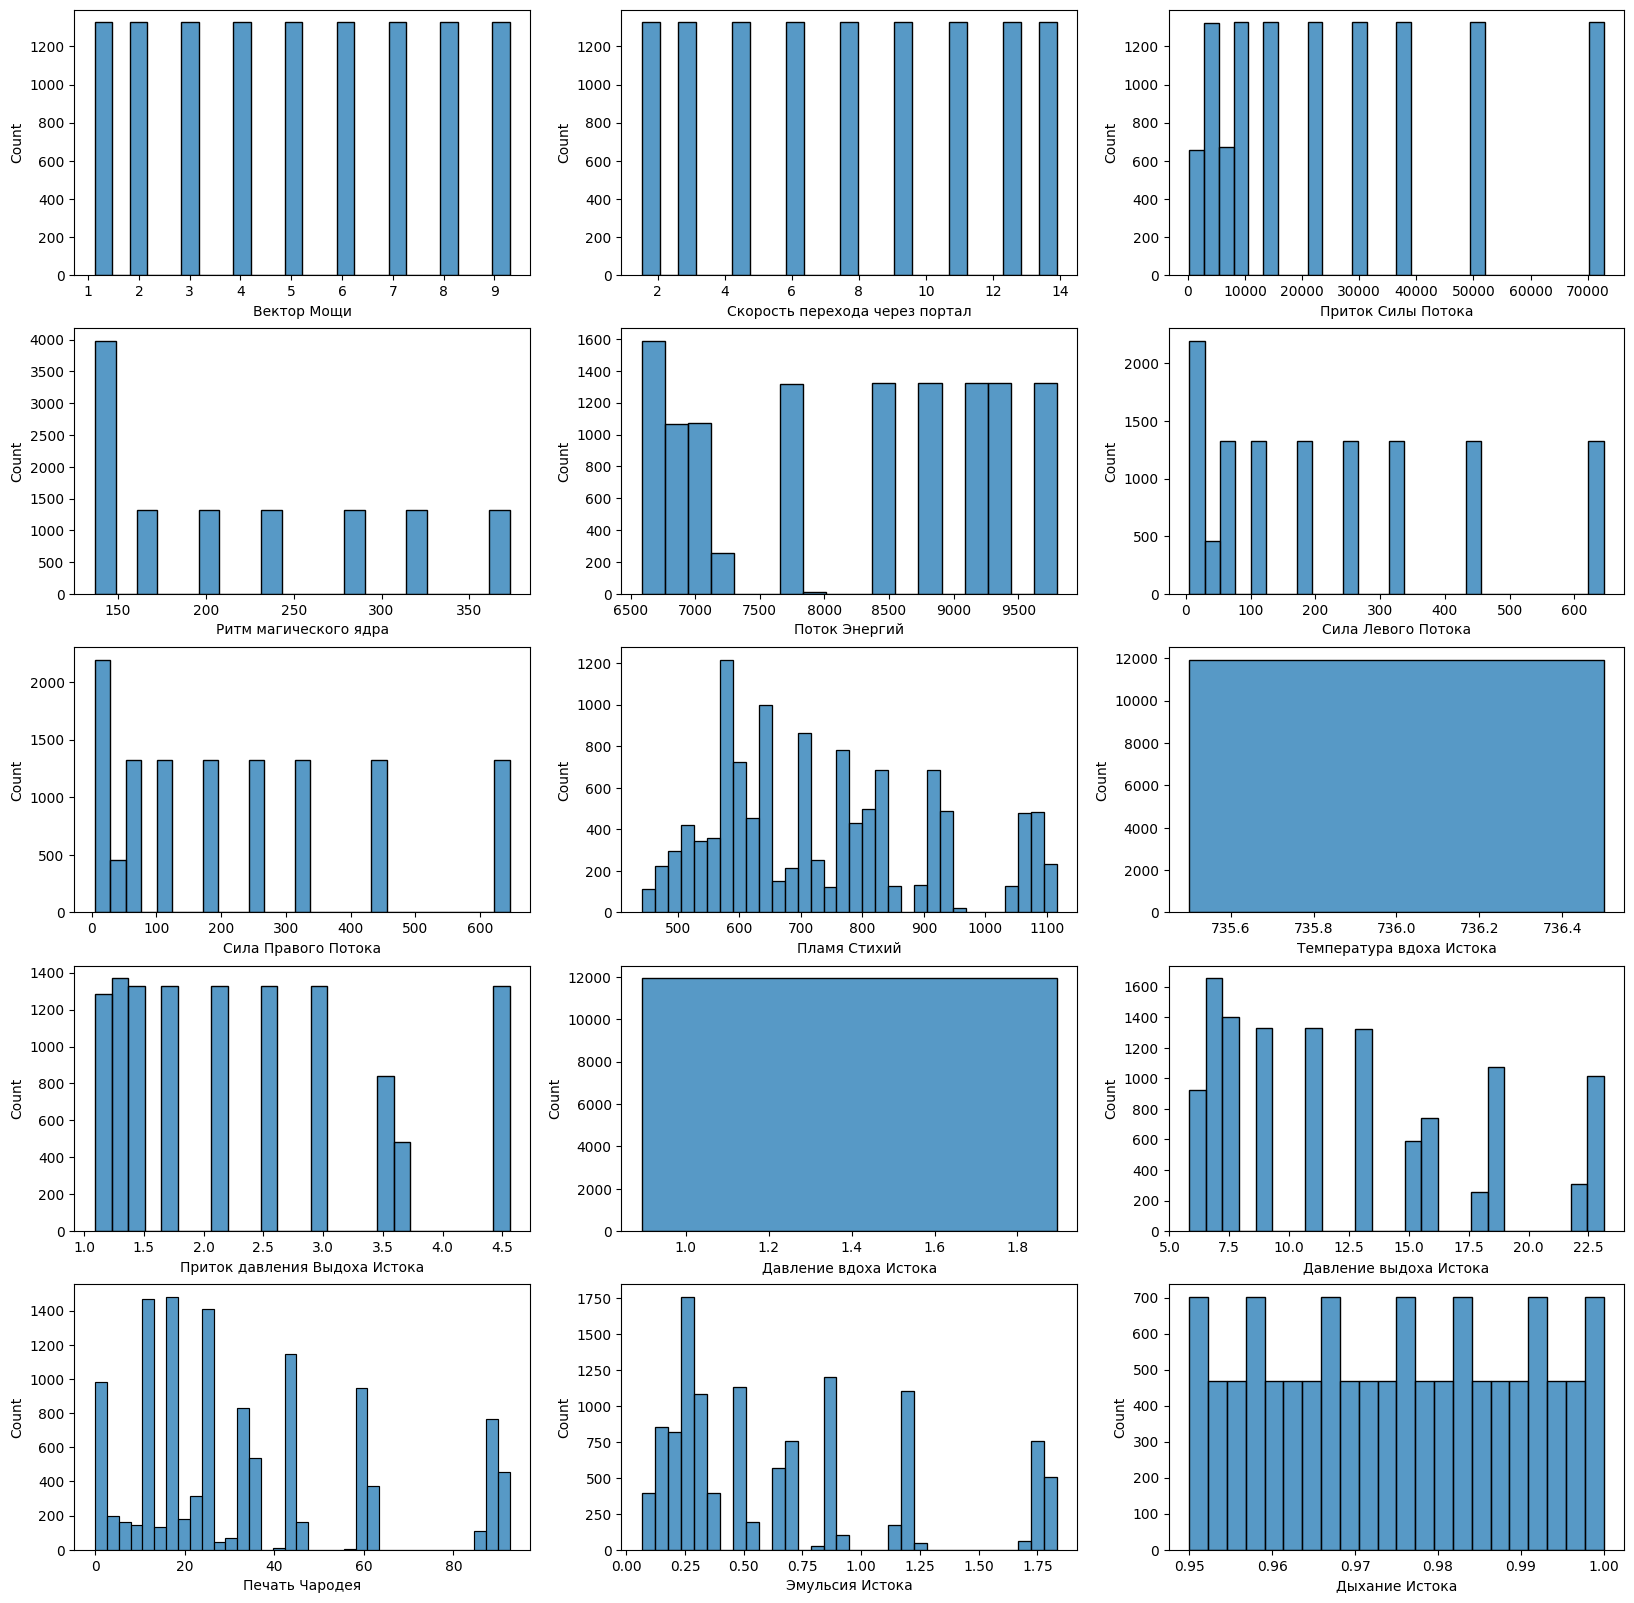

In [ ]:
draw_sns(X, visualization_function=sns.histplot)

### 5.3.2. <a id='toc5_3_2_'></a>[Квартильный анализ (IQR)](#toc0_)

#### 5.3.2.1. <a id='toc5_3_2_1_'></a>[Визуализация границ](#toc0_)

Воспользуемся следующей стратегией: квартильный анализ.

Квартильный анализ (IQR) — это метод, котоырй используется для выявления выбросов на основе квартильного размаха.

Процентиль уровня $q$ -- это такое значение $x_q$ случайной величины $X$, что $P(X < x_q) = q$.

Квартили — это значения, которые делят упорядоченный набор данных на четыре равные части:

- Q1 (первый квартиль): 25-й процентиль, ниже которого находится 25% данных.
- Q2 (второй квартиль): 50-й процентиль, также известный как медиана, ниже которой находится 50% данных.
- Q3 (третий квартиль): 75-й процентиль, ниже которого находится 75% данных.

Межквартильный размах (IQR) — это разница между третьим и первым квартилями: IQR = Q3 − Q1. IQR используется для оценки рассеивания данных и является более устойчивым к выбросам по сравнению с дисперсией или стандартным отклонением.

Алгоритм поиска выбросов:
1. для данного признака вычисляется Q1, Q3 и IQR;
2. определяются границы выбросов:
    - нижняя граница: Q1 - 1.5 $\cdot$ IQR
    - верхняя граница: Q1 + 1.5 $\cdot$ IQR
3. значения, которые меньше нижней границы или больше верхней границы, считаются выбросами.

Первоначально построим диаграмму "Ящик с усами" для каждого признака. Она вычисляет IQR и смотрит, какой процент данных находится внутри предельного значения границ. Выбросы находятся вне "усов" (границ) и помечаются точками.

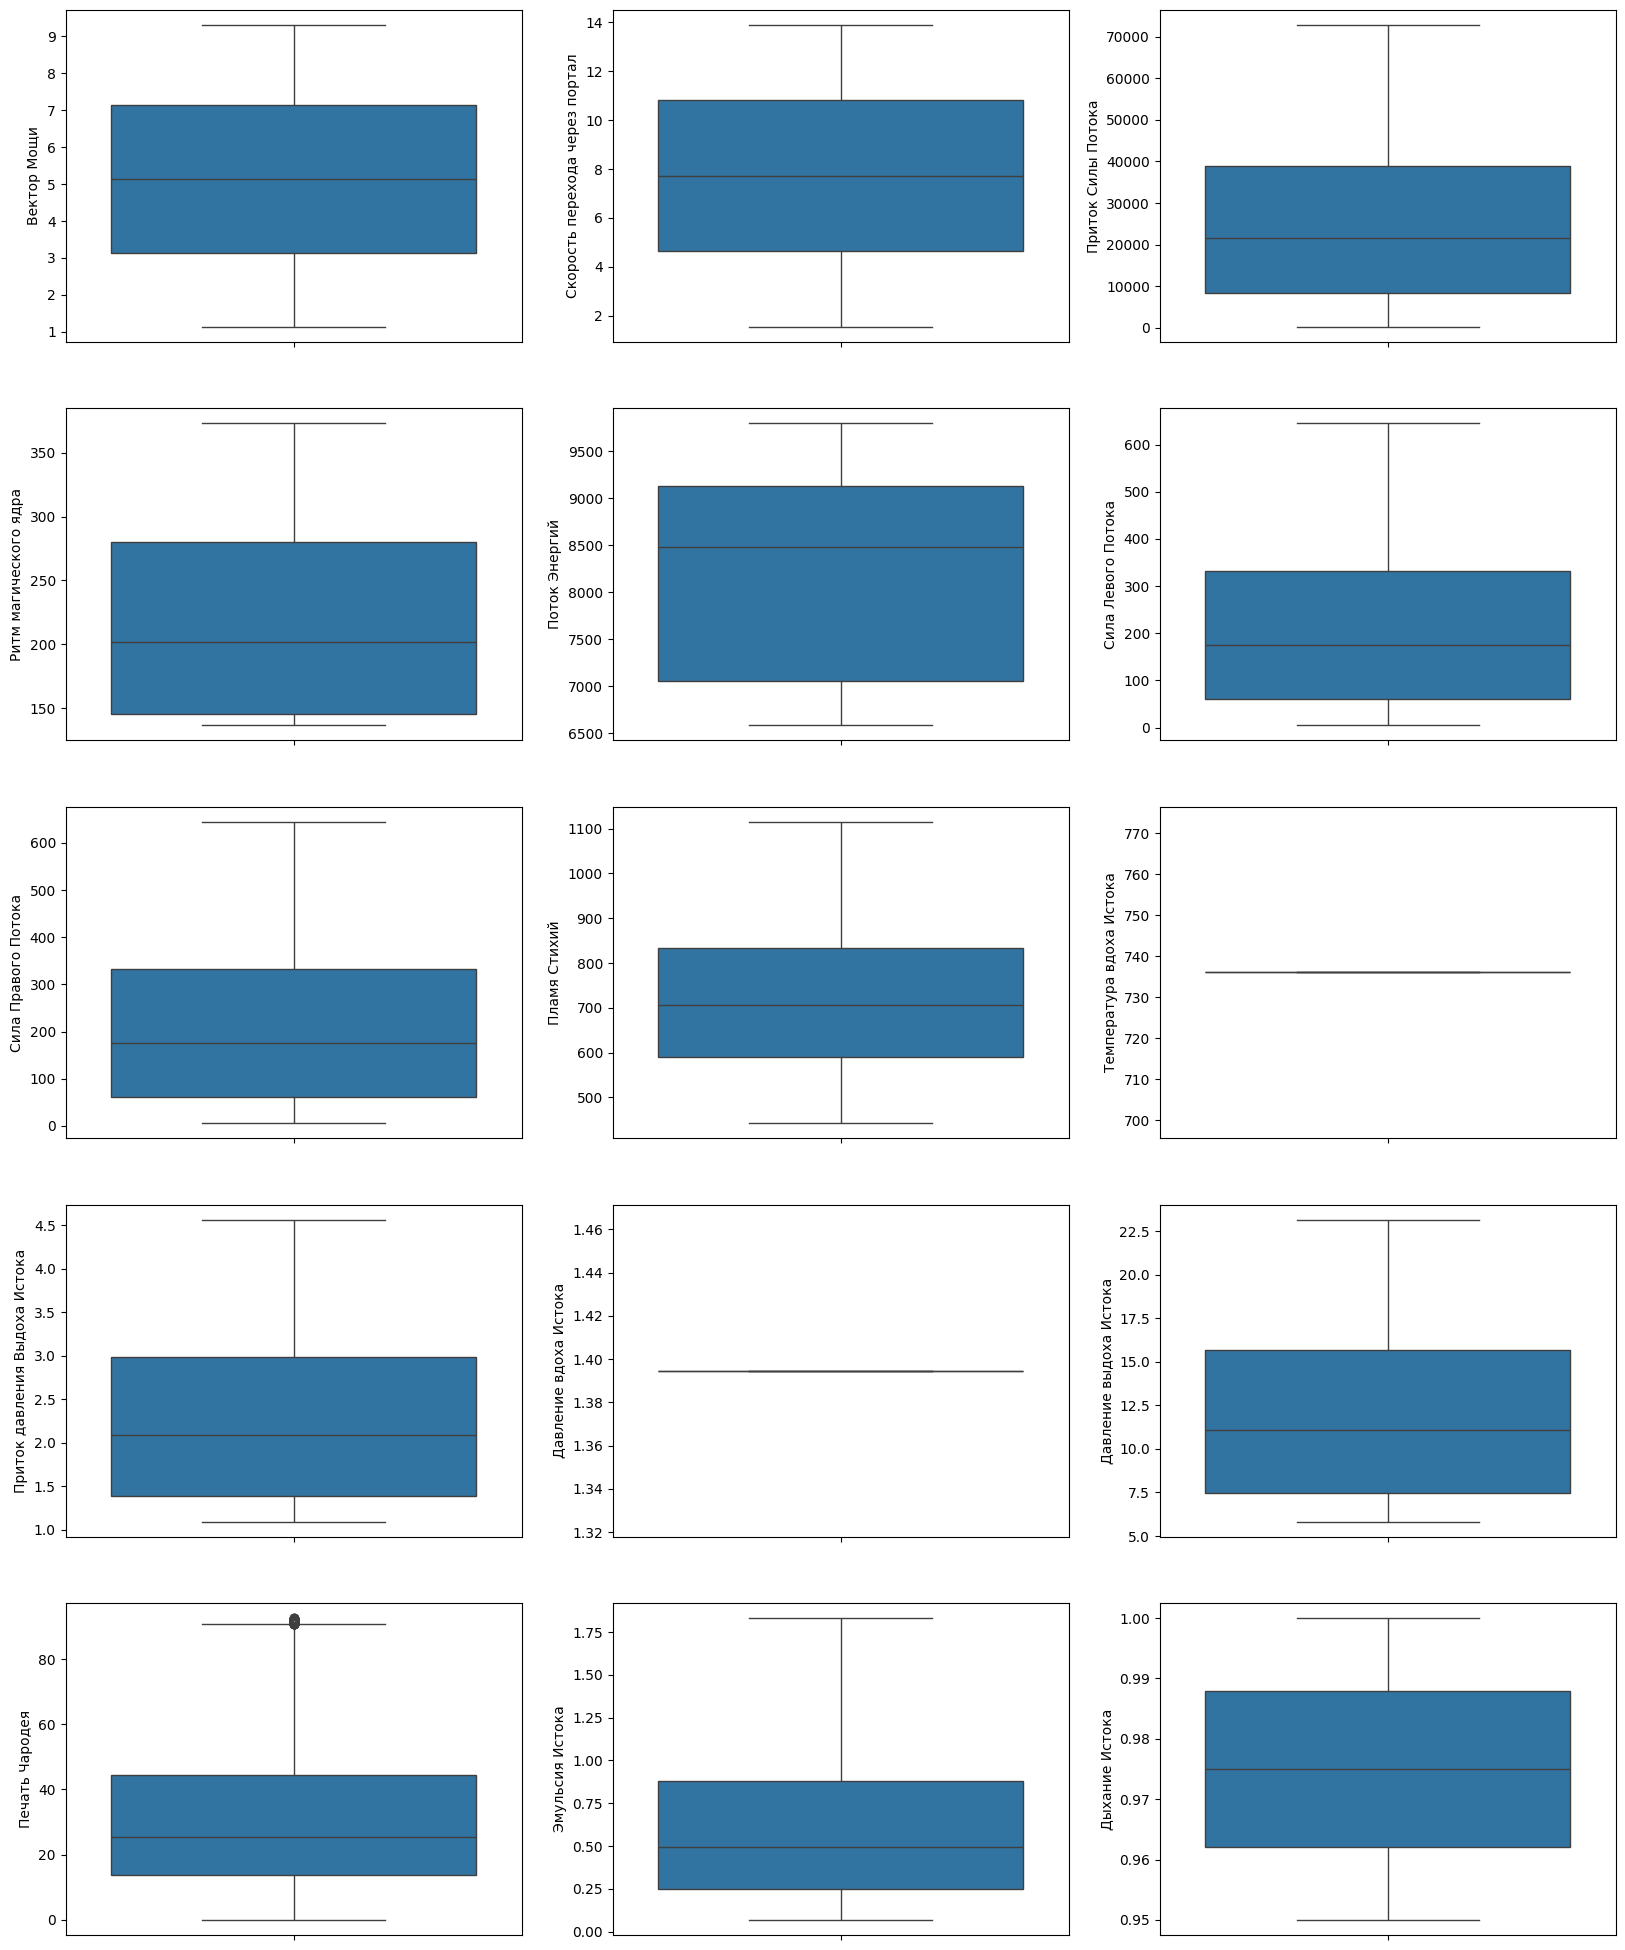

In [ ]:
draw_sns(X, sns.boxplot, figsize=(20, 25))

По графику видно, что выбросы присутствуют в некоторых признаках, поэтом создадим функции для вычисления границ и поиска выбросов.

#### 5.3.2.2. <a id='toc5_3_2_2_'></a>[Реализация алгоритма](#toc0_)

Первоначально создадим функцию для вычисления границ.

In [ ]:
def calc_bounds(x: t.Iterable[float]) -> t.Tuple[float, float]:
    """Вычисление левой и правой границ IQR

    Args:
        x (t.Iterable[float]): Вариационный ряд

    Returns:
        t.Tuple[float, float]: Левая и правая границы
    """
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

Также реализуем функцию, которая проверяет, содержит ли вариационный ряд выбросы.

In [ ]:
def check_feature_outliers_iqr(x: pd.Series) -> np.ndarray[bool]:
    """Проверка выбросов при помощи IQR

    Args:
        x (pd.Series): Вариационный ряд

    Returns:
        np.ndarray[bool]: Массив меток для каждого объекта вариационного ряда, является ли значение выбросом
    """
    lower_bound, upper_bound = calc_bounds(x)
    return ((x < lower_bound) | (x > upper_bound)).values

И, наконец, реализуем функцию, которая проверяет, содержит ли объект датасета выброс внутри своего разложения в признаковом пространстве. Данная функция обобщает методы исследования, поэтому принимает в качестве аргумента outliers_method: алгоритм вычисления выбросов.

In [ ]:
def check_dataset_outliers(df: pd.DataFrame, outliers_method: t.Callable[..., np.ndarray[bool]], **kwargs) -> np.ndarray[bool]:
    """Проверка выбросов у объектов датасета

    Args:
        df (pd.DataFrame): Датасет
        outliers_method (t.Callable[..., np.ndarray[bool]]): Правило детектирования выбросов

    Returns:
        np.ndarray[bool]: Массив меток для каждого объекта датасета, содержит ли объект выбросы
    """
    outliers_flags = [
        outliers_method(df[column], **kwargs) for column in df.columns
    ]
    return np.any(np.array(outliers_flags), axis=0)

#### 5.3.2.3. <a id='toc5_3_2_3_'></a>[Проверка на выбросы](#toc0_)

Проверим набор данных при помощи данного алгоритма и выведем только те строки, которые были помечены, как выбросы.

In [ ]:
outliers_objects_iqr = df.loc[check_dataset_outliers(X, check_feature_outliers_iqr)]
outliers_objects_iqr

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия
8,9.3,13.88988,72763.329,372.843693,9778.528,644.905,644.905,1115.797,736,NaN,4.498,1.394603,22.811,NaN,92.556,1.832,0.950,0.975
17,9.3,13.88988,72763.515,372.844321,9779.311,644.963,644.963,1114.887,736,NaN,4.496,1.394603,22.784,NaN,92.448,1.830,0.950,0.976
26,9.3,13.88988,72764.565,372.844530,9780.103,645.076,645.076,1113.985,736,NaN,4.495,1.394603,22.756,NaN,92.342,1.828,0.950,0.977
35,9.3,13.88988,72765.436,372.844740,9780.887,645.040,645.040,1113.084,736,NaN,4.494,1.394603,22.729,NaN,92.235,1.826,0.950,0.978
44,9.3,13.88988,72766.645,372.844740,9781.672,644.879,644.879,1112.188,736,NaN,4.493,1.394603,22.701,NaN,92.129,1.824,0.950,0.979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4454,9.3,13.88988,72759.855,372.842017,9755.931,645.021,645.021,1093.797,736,NaN,4.521,1.394603,22.935,NaN,91.068,1.803,0.969,0.975
4463,9.3,13.88988,72761.521,372.841284,9756.799,644.961,644.961,1092.895,736,NaN,4.520,1.394603,22.908,NaN,90.961,1.801,0.969,0.976
4688,9.3,13.88988,72759.281,372.842541,9754.742,644.761,644.761,1092.665,736,NaN,4.522,1.394603,22.942,NaN,90.990,1.801,0.970,0.975
4697,9.3,13.88988,72760.783,372.842541,9755.613,644.736,644.736,1091.762,736,NaN,4.521,1.394603,22.914,NaN,90.883,1.799,0.970,0.976


### 5.3.4. <a id='toc5_3_4_'></a>[Удаление объектов с выбросами](#toc0_)

Теперь необходимо принять решение по поводу тех объектов, которые были помечены в качестве объектов с выбросами. Для этого соберем индексы таких записей после работы каждого алгоритма и найдем пересечение этих индексов. Это значит, что все алгоритмы посчитали данные объекты как объекты с выбросами, и их необходимо удалить из набора данных.

In [ ]:
outliers_objects = np.intersect1d(
    outliers_objects_iqr.index, 
    outliers_objects_z_score_2.index
)
outliers_objects

array([   8,   17,   26,   35,   44,   53,   62,   71,   80,   89,   98,
        107,  116,  125,  134,  143,  152,  242,  251,  260,  269,  278,
        287,  296,  305,  314,  323,  332,  341,  350,  359,  368,  377,
        476,  485,  494,  503,  512,  521,  530,  539,  548,  557,  566,
        575,  584,  593,  602,  710,  719,  728,  737,  746,  755,  764,
        773,  782,  791,  800,  809,  818,  827,  944,  953,  962,  971,
        980,  989,  998, 1007, 1016, 1025, 1034, 1043, 1052, 1061, 1178,
       1187, 1196, 1205, 1214, 1223, 1232, 1241, 1250, 1259, 1268, 1277,
       1286, 1412, 1421, 1430, 1439, 1448, 1457, 1466, 1475, 1484, 1493,
       1502, 1511, 1646, 1655, 1664, 1673, 1682, 1691, 1700, 1709, 1718,
       1727, 1736, 1880, 1889, 1898, 1907, 1916, 1925, 1934, 1943, 1952,
       1961, 2114, 2123, 2132, 2141, 2150, 2159, 2168, 2177, 2186, 2195,
       2348, 2357, 2366, 2375, 2384, 2393, 2402, 2411, 2420, 2582, 2591,
       2600, 2609, 2618, 2627, 2636, 2645, 2816, 28

Получаем 192 выброса.

In [ ]:
outliers_objects.shape

(192,)

## 5.4. <a id='toc5_4_'></a>[Поиск аномалий в данных](#toc0_)

Перейдем к поиску аномальных объектов в данных. 

Аномальные объекты — это точки данных, которые значительно отклоняются от большинства других точек в наборе данных. Эти объекты могут быть результатом ошибок измерения, исключительных событий или других факторов, которые делают их нетипичными по сравнению с остальными данными.

Поэтому данные объекты могут негативно сказаться результатах обучения и предсказаниях. Их необходимо детектировать и удалить.

Для этого воспользуемся несколькими алгоритмами детекции аномалий, получим от них предсказания, а затем удалим те объекты, которые были помочены ВСЕМИ алгоритмами. Алгоритмы будем выбирать так, чтобы они анализировали разную пространственную информацию расположения точек в признаковом пространстве для большей объективности.

Для визуализации работа алгоритмов реализуем функцию, которая будет помечать аномальные объекты.

In [ ]:
def draw_anomaly(X_2d: np.ndarray[float], anomaly_mask: np.ndarray[bool]) -> None:
    """Визуализация аномальных объектов

    Args:
        X_2d (np.ndarray[float]): Датасет, пониженный до двумерного пространства
        anomaly_mask (np.ndarray[bool]): Маска аномальных объектов
    """
    plt.scatter(X_2d[:, 0], X_2d[:, 1])
    plt.scatter(X_2d[anomaly_mask, 0], X_2d[anomaly_mask, 1], c="red", marker='x')

Также реализуем функцию, которая строит круговую диаграмму с долями аномальных объектов.

In [ ]:
def draw_anomaly_pie(anomaly_mask: np.ndarray[bool]) -> None:
    """Визуализация долей аномальных и неаномальных объектов в данных

    Args:
        anomaly_mask (np.ndarray[bool]): Маска аномальных объектов
    """
    _, counts = np.unique(anomaly_mask, return_counts=True)

    plt.pie(counts, labels=counts, autopct='%1.0f%%');
    plt.legend([
        'Нормальные объекты', 'Аномалии'
    ], loc='lower right');

Загрузим данные для анализа и отбросим целевой столбец, так как вычисляются только аномалии в признаковом пространстве.

In [ ]:
X = pd.read_csv('./data/outlier/data_drop_nan.csv').drop(columns=['Гармония Бессмертия'])

Для визуализации необходимо понизить пространство до двумерного. Сделаем это при помощи алгоритма UMAP, который способен эффективно сохранять как локальную, так и глобальную структуру данных при снижении размерности.

In [ ]:
from umap import UMAP


X_2d = UMAP().fit_transform(X)

Детекцию аномалий будем осуществлять при помощи библиотеки pyod, которая предоставляет интерфейс для работы с алгоритмами поиска.

### 5.4.1. <a id='toc5_4_1_'></a>[Поиск на основе IsolationForest](#toc0_)

Для выделений аномалий Isolation Forest использует случайные разделения данных, что позволяет быстро и точно идентифицировать выбросы. Алгоритм работает, строя множество случайных деревьев решений и измеряя длину пути, необходимую для изоляции каждой точки данных, где короткие пути указывают на аномалии.

In [ ]:
from pyod.models.iforest import IForest


isf = IForest().fit(X)
isf_anomaly = isf.predict(X)

Данный алгоритм посчитал 1175 объектов аномальными.

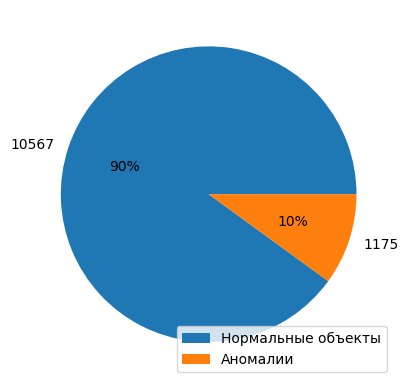

In [136]:
draw_anomaly_pie(isf_anomaly)

Визуализируем в двумерной проекции датасета объекты с выбросами. Видим, что данный алгоритм отметил плотный кластер данных в центре графика.

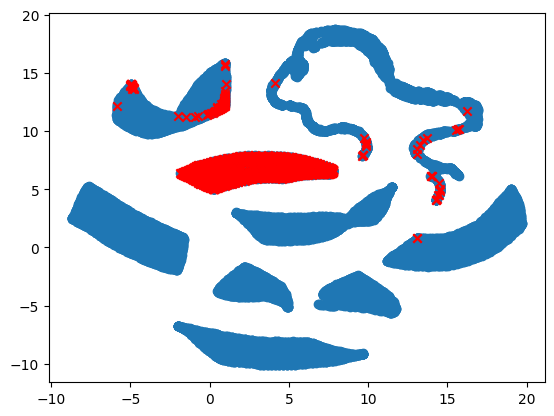

In [ ]:
draw_anomaly(X_2d, isf_anomaly.astype(bool))

### 5.4.2. <a id='toc5_4_2_'></a>[Поиск на основе SVM](#toc0_)

Алгоритм одноклассового SVM (OCSVM) для поиска аномалий строит гиперплоскость, которая максимально разделяют нормальные данные от аномальных, используя метод опорных векторов для оптимизации границы разделения, исследуя пространственную информацию в признаковом пространстве

In [ ]:
from pyod.models.ocsvm import OCSVM


ocsvm = OCSVM().fit(X)
ocsvm_anomaly = ocsvm.predict(X)

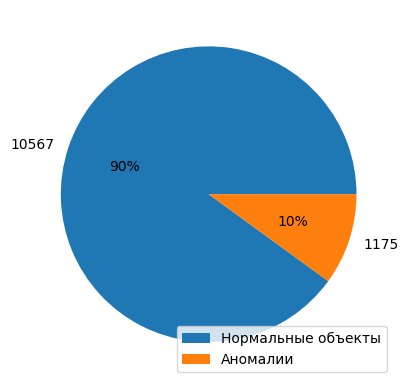

In [137]:
draw_anomaly_pie(ocsvm_anomaly)

данный алгоритм поместил аномальные данные в другой изолированный остров.

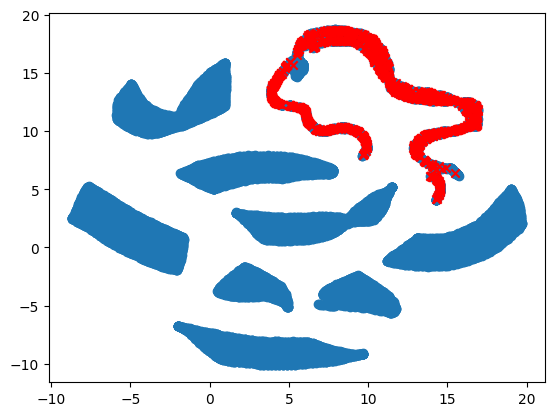

In [ ]:
draw_anomaly(X_2d, ocsvm_anomaly.astype(bool))

### 5.4.4. <a id='toc5_4_4_'></a>[Удаление аномальных объектов](#toc0_)

В результате мы получили 3 модели, каждая из которых анализировала пространственную информацию точек, представленных в признаковом пространстве. Для объективной картины аномальными пометим только те объекты, в которых уверены все 3 алгоритма. Для этого воспользуемся функцией np.all из numpy.

In [ ]:
anomalies = np.all(np.array([
    isf_anomaly,
    ocsvm_anomaly,
]), axis=0)
anomalies

array([False, False, False, ..., False, False, False])

Визуализируем результат работы трех алгоритмов: 13 объектов были помочены тремя моделями, ка каномальные.

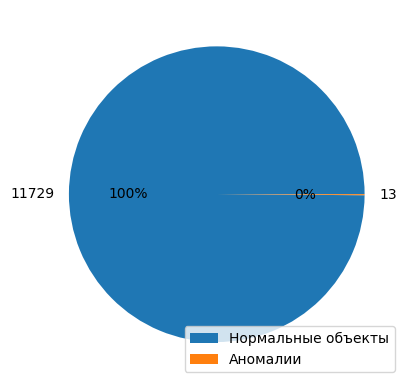

In [147]:
draw_anomaly_pie(anomalies)

на двумерном представлении датасета они располагаются все в локальном кластере на границах.

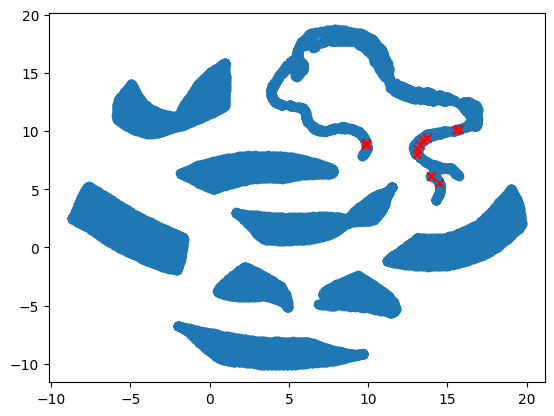

In [149]:
draw_anomaly(X_2d, anomalies)

Вычислим индексы аномальных объектов в исходном датасете, чтобы затем откинуть их.

In [ ]:
anomaly_index = X.loc[anomalies].index
anomaly_index

Index([172, 329, 547, 766, 775, 811, 995, 1537, 1670, 1768, 2224, 2449, 2683], dtype='int64')